# Genz Continuous Integrand Family

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import itertools
from sklearn.model_selection import train_test_split
import mlflow

In [3]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [4]:
from solstice.kernels import RBF, RFF, Matern32
from solstice.gp import GP, LowRankGP, fitgp
from solstice.transforms import ARD, FiniteARD
from ffbq.helpers import grid, regrid
from ffbq.bq import BQ
from ffbq.eval import generate_data, metric_gp_bq
from ffbq.measures import halton_samples, qmc

In [5]:
from ffbq.genz import GenzContinuous

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


# Define Experiment

In [7]:
key = jax.random.PRNGKey(2023)
EXPERIMENT = "continuous_dev"

In [8]:
def gaussian_bq(gp, m, X, y, bounds, key, diag=None):
    bq = BQ(gp, m)
    mu, sigma = bq(X, y, bounds=bounds, key=key, diag=diag)
    return mu, sigma

def mc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="mc")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, key=key,
                   diag=diag)
    return mu, sigma

def qmc_bq(gp, m, X_train, y_train, R, bounds, key, diag=None):
    bq = BQ(gp, m, operator="qmc")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, key=key,
                   diag=diag)
    return mu, sigma

def fft_bq(gp, m, X_train, y_train, sr, bounds, diag=None):
    bq = BQ(gp, m, operator="fft")
    mu, sigma = bq(X_train, y_train, bounds=bounds, sr=sr, diag=diag)
    return mu, sigma

def lr_qmc_bq(gp, m, X_train, y_train, R, bounds, diag=None):
    bq = BQ(gp, m, operator="lr")
    mu, sigma = bq(X_train, y_train, bounds=bounds, R=R, diag=diag)
    return mu, sigma

def lr_fft_bq(gp, m, X_train, y_train, sampling_rate, bounds, diag=None):
    bq = BQ(gp, m, operator="lrfft")
    mu, sigma = bq(X_train, y_train, bounds=bounds, sr=sampling_rate, diag=diag)
    return mu, sigma

## Define Run

In [9]:
diag = 1e-4
lr = 0.01
epochs = 200

In [10]:
sols_d = {
    2: (0.13481087196020605, 0.0), 3: (0.04949796868834639, 0.0), 
    4: (0.018173971198671073, 0.0), 5: (0.006672864319134955, 0.0), 
    6: (0.0024500489042725187, 0.0), 7:(0.0008995746573347301, 0.0), 
    8: (0.00033029322913012574, 0.0)
}

sols2_d = {
    2: (0.1470510688313898, 0.0), 3: (0.05639002384646558, 0.0), 
    4: (0.021624016844454134, 0.0), 5: (0.008292213278050322, 0.0), 
    6: (0.0031798347894049566, 0.0), 7: (0.0012193788255151425, 0.0), 
    8: (0.0004675981044892362, 0.0)
}

In [11]:
SRs = [4, 8, 16, 32, 64, 128]
Ns = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ds = [2, 3, 4, 5, 6, 7, 8]
# seeds = jax.random.split(jax.random.PRNGKey(2023), 10)
run_params = itertools.product(SRs, Ns, ds)

In [12]:
def single_run(d, R, N, sampling_rate, key, EXPERIMENT=None, log=True):
    print(f'd: {d}, R: {R}, N: {N}, sr: {sampling_rate}')

    gp_diag = 1e-4
    lr_gp_diag = 1e-4

    if EXPERIMENT is None:
        EXPERIMENT = "continuous_dev"

    sol = sols2_d[d]
    genz = GenzContinuous(d, bound=2)
    ls_init = (genz.bounds[1,:] - genz.bounds[0,:]) / 2

    # make data
    train, val, test = generate_data(genz, N * 3, N, N, noise=None, key=key)
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    Nconv = grid(genz.bounds, sampling_rate=sampling_rate).shape[0]
    Nconv_cap = 100000
    Nrff_cap = 500000

    # --------------------------------------- TRAIN GPS -------------------------------------- #

    ###### BASIC BQ GP
    def build_train_bq_gp(X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(ARD(ls_init, RBF()), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_bq_opt = optax.adam(lr)
    print("training basic gp...")
    _, gp_bq, _ = build_train_bq_gp(X_train, y_train, gp_bq_opt, epochs, ls_init, diag=gp_diag)

    ###### RBF GP
    def build_train_rbf_gp(support, X, y, opt, epochs, ls_init, diag):
        gp_pre = GP(FiniteARD(ls_init, RBF(), support), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: t.kernel.scale, verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_rbf_opt = optax.adam(lr)
    print("training rbf gp...")
    _, gp_rbf, _ = build_train_rbf_gp(genz.bounds, X_train, y_train, gp_rbf_opt, epochs, ls_init, diag=gp_diag)

    ###### MATERN 3/2 GP
    def build_train_mat32_gp(d, R, support, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = GP(FiniteARD(ls_init, RFF(key, d, R, base_kernel=Matern32()), support), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_mat32_opt = optax.adam(lr)
    _, gp_mat32, _ = build_train_mat32_gp(d, R, genz.bounds, X_train, y_train, gp_mat32_opt, epochs, ls_init, diag=gp_diag, key=key)

    # ###### RFF GP
    # def build_train_rff(d, R, X, y, opt, epochs, ls_init, diag, key):
    #     gp_pre = GP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

    #     # train
    #     gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
    #                     verbose=False, solver="full")
    #     return gp_pre, gp, loss

    # gp_rff_opt = optax.adam(lr * 10)
    # _, gp_rff, _ = build_train_rff(d, R, X_train, y_train, gp_rff_opt, epochs, ls_init, diag, key=key)


    ###### FINITE RFF GP
    def build_train_fin(d, R, support, X, y, opt, epochs, ls_init, diag, key):

        gp_pre = GP(FiniteARD(ls_init, RFF(key, d, R), support), X, diag=diag)

        gp, loss = fitgp(
            gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
            verbose=False, solver="full"
        )
        
        return gp_pre, gp, loss

    gp_fin_opt = optax.adam(lr)
    print("training finite gp...")
    _, gp_fin, _ = build_train_fin(d, R, genz.bounds, X_train, y_train, gp_fin_opt, epochs, ls_init, diag=gp_diag, key=key)
    
    ###### LOW RANK RBF GP
    def build_train_lrgp_rbf(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_lr_rbf_opt = optax.adam(lr)
    print("training low rank rbf gp...")
    _, gp_lr_rbf, _ = build_train_lrgp_rbf(d, R, X_train, y_train, gp_lr_rbf_opt, epochs, ls_init, diag=lr_gp_diag, key=key)

    ###### LOW RANK MATERN32 GP
    def build_train_lrgp_mat32(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R, base_kernel=Matern32())), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale), 
                        verbose=False, solver="full")
        return gp_pre, gp, loss

    gp_lr_mat32_opt = optax.adam(lr)
    print("training low rank matern 3/2 gp...")
    _, gp_lr_mat32, _ = build_train_lrgp_mat32(d, R, X_train, y_train, gp_lr_mat32_opt, epochs, ls_init, diag=lr_gp_diag, key=key)

    ###### LOW RANK RFF GP
    def build_train_lrgp_rff(d, R, X, y, opt, epochs, ls_init, diag, key):
        gp_pre = LowRankGP(ARD(ls_init, RFF(key, d, R)), X, diag=diag)

        # train
        gp, loss = fitgp(gp_pre, y, opt, epochs, to_train=lambda t: (t.kernel.scale, t.kernel.kernel.w), 
                        verbose=False)
        return gp_pre, gp, loss

    gp_lr_rff_opt = optax.adam(lr)
    print("training low rank RFF gp...")
    _, gp_lr_rff, _ = build_train_lrgp_rff(d, R, X_train, y_train, gp_lr_rff_opt, epochs, ls_init, diag=lr_gp_diag, key=key)

    # make test GPs for BQ
    gp_bq = eqx.tree_at(lambda t: t.X, gp_bq, replace_fn=lambda _: X_val)
    gp_rbf = eqx.tree_at(lambda t: t.X, gp_rbf, replace_fn=lambda _: X_val)
    gp_mat32 = eqx.tree_at(lambda t: t.X, gp_mat32, replace_fn=lambda _: X_val)
    # gp_rff = eqx.tree_at(lambda t: t.X, gp_rff, replace_fn=lambda _: X_val)
    gp_fin = eqx.tree_at(lambda t: t.X, gp_fin, replace_fn=lambda _: X_val)
    gp_lr_rbf = eqx.tree_at(lambda t: t.X, gp_lr_rbf, replace_fn=lambda _: X_val)
    gp_lr_mat32 = eqx.tree_at(lambda t: t.X, gp_lr_mat32, replace_fn=lambda _: X_val)
    gp_lr_rff = eqx.tree_at(lambda t: t.X, gp_lr_rff, replace_fn=lambda _: X_val)

    # ---------------------------------------- RUN BQ ---------------------------------------- #
    m = tfd.MultivariateNormalDiag(jnp.ones(d) * 0.5, jnp.ones(d) * 10)
    print("running BQ models...")

    ########## GAUSSIAN BQ
    rbf_res, rbf_var = gaussian_bq(gp_bq, m, X_val, y_val, genz.bounds, key, diag=None)

    ########## MC
    if Nconv > Nconv_cap:
        Nconv_mc = Nconv_cap
        print(f"Capping N mc from {Nconv} to {Nconv_cap}")
    else:
        Nconv_mc = Nconv

    rbf_mc_res, rbf_mc_var = mc_bq(gp_rbf, m, X_val, y_val, Nconv_mc, genz.bounds, key)
    mat32_mc_res, mat32_mc_var = mc_bq(gp_mat32, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=None)
    fin_mc_res, fin_mc_var = mc_bq(gp_fin, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=None)

    ########## QMC
    rbf_qmc_res, rbf_qmc_var = qmc_bq(gp_rbf, m, X_val, y_val, Nconv_mc, genz.bounds, key)
    mat32_qmc_res, mat32_qmc_var = qmc_bq(gp_mat32, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=None)
    fin_qmc_res, fin_qmc_var = qmc_bq(gp_fin, m, X_val, y_val, Nconv_mc, genz.bounds, key, diag=None)

    ########## FFBQ
    rbf_fft_res, rbf_fft_var = fft_bq(gp_rbf, m, X_val, y_val, sampling_rate, genz.bounds)
    mat32_fft_res, mat32_fft_var = fft_bq(gp_mat32, m, X_val, y_val, sampling_rate, genz.bounds, diag=None)
    fin_fft_res, fin_fft_var = fft_bq(gp_fin, m, X_val, y_val, sampling_rate, genz.bounds, diag=None)

    ########## SSBQ (QMC)
    if Nconv > Nrff_cap:
        Nrff = Nrff_cap
        print(f"Capping N RFF from {Nconv} to {Nrff_cap}")
    else:
        Nrff = Nconv
    lr_rbf_res, lr_rbf_var = lr_qmc_bq(gp_lr_rbf, m, X_val, y_val, Nrff, genz.bounds)
    lr_mat32_res, lr_mat32_var = lr_qmc_bq(gp_lr_mat32, m, X_val, y_val, Nrff, genz.bounds, diag=None)
    lr_rff_res, lr_rff_var = lr_qmc_bq(gp_lr_rff, m, X_val, y_val, Nrff, genz.bounds, diag=None)

    # ########## SSBQ (FFT)
    # if d < 3:
    #     lrfft_rbf_res, lrfft_rbf_var = lr_fft_bq(gp_lr_rbf, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)
    #     lrfft_mat32_res, lrfft_mat32_var = lr_fft_bq(gp_lr_mat32, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)
    #     lrfft_rff_res, lrfft_rff_var = lr_fft_bq(gp_lr_rff, m, X_val, y_val, sampling_rate, genz.bounds, diag=diag_lr_fft)

    # ----------------------------------- ERROR AND OUTPUT ----------------------------------- #
    rbf_err = jnp.abs(rbf_res - sol[0]) / sol[0]
    qmc_rel_errs = jnp.abs(jnp.array([rbf_qmc_res, mat32_qmc_res, fin_qmc_res]) - sol[0]) / sol[0]
    mc_rel_errs = jnp.abs(jnp.array([rbf_mc_res, mat32_mc_res, fin_mc_res]) - sol[0]) / sol[0]
    ffbq_rel_errs = jnp.abs(jnp.array([rbf_fft_res, mat32_fft_res, fin_fft_res]) - sol[0]) / sol[0]
    ssbq_rel_errs = jnp.abs(jnp.array([lr_rbf_res, lr_mat32_res, lr_rff_res]) - sol[0]) / sol[0]
    if d < 3:
        ssbq_fft_rel_errs = None
        # ssbq_fft_rel_errs = jnp.abs(jnp.array([lrfft_rbf_res, lrfft_mat32_res, lrfft_rff_res]) - sol[0]) / sol[0]
    else:
        ssbq_fft_rel_errs = None

    print(f"""
        Gaussian: {rbf_err} \n 
        MC: {mc_rel_errs} \n
        QMC: {qmc_rel_errs} \n 
        FFBQ: {ffbq_rel_errs} \n 
        SSBQ (QMC): {ssbq_rel_errs} \n
        SSBQ (FFT): {ssbq_fft_rel_errs} \n
    """)

    artifacts = {
        "genz": genz,
        "m": m,
        "val": (X_val, y_val),
        "test": (X_test, y_test),
        "gps": {
            "bq": gp_bq,
            "rbf": gp_rbf,
            "mat32": gp_mat32,
            # "rff": gp_rff,
            "fin": gp_fin,
            "lr_rbf": gp_lr_rbf,
            "lr_mat32": gp_lr_mat32,
            "lr_rff": gp_lr_rff
        }
    }
    
    if not log:
        return artifacts

    # -------------------------------------- SAVE MODELS ------------------------------------- #
    ########## GAUSSIAN BQ
    metric_gp_bq(
        gp=gp_bq, bq_res=rbf_res, bq_var=rbf_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="gaussian", 
        epochs=epochs, lr=lr, key=key
    )

    ########## MC
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_mc_res, bq_var=rbf_mc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_mc_res, bq_var=mat32_mc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_mc_res, bq_var=fin_mc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="mc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R, diag=1e-1
    )

    ########## QMC
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_qmc_res, bq_var=rbf_qmc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_qmc_res, bq_var=mat32_qmc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_qmc_res, bq_var=fin_qmc_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="qmc", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv_mc, R=RBF
    )

    ########## FFBQ
    metric_gp_bq(
        gp=gp_rbf, bq_res=rbf_fft_res, bq_var=rbf_fft_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="rbf", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv
    )
    metric_gp_bq(
        gp=gp_mat32, bq_res=mat32_fft_res, bq_var=mat32_fft_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol,
        experiment=EXPERIMENT, gptype="gp", ktype="mat32", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
    )
    metric_gp_bq(
        gp=gp_fin, bq_res=fin_fft_res, bq_var=fin_fft_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="gp", ktype="fin", bqtype="ffbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
    )

    ########## SSBQ
    metric_gp_bq(
        gp=gp_lr_rbf, bq_res=lr_rbf_res, bq_var=lr_rbf_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )
    metric_gp_bq(
        gp=gp_lr_mat32, bq_res=lr_mat32_res, bq_var=lr_mat32_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="mat32", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )
    metric_gp_bq(
        gp=gp_lr_rff, bq_res=lr_rff_res, bq_var=lr_rff_var,
        y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
        experiment=EXPERIMENT, gptype="lr", ktype="rff", bqtype="ssbq", 
        epochs=epochs, lr=lr, key=key, Nconv=Nrff, R=R
    )

    # ########## SSBQ (FFT)
    # if d < 3:
    #     metric_gp_bq(
    #         gp=gp_lr_rbf, bq_res=lrfft_rbf_res, bq_var=lrfft_rbf_var,
    #         y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
    #         experiment=EXPERIMENT, gptype="lr", ktype="rbf", bqtype="lrfft", 
    #         epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
    #     )
    #     metric_gp_bq(
    #         gp=gp_lr_mat32, bq_res=lrfft_mat32_res, bq_var=lrfft_mat32_var,
    #         y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
    #         experiment=EXPERIMENT, gptype="lr", ktype="mat32", bqtype="lrfft", 
    #         epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
    #     )
    #     metric_gp_bq(
    #         gp=gp_lr_rff, bq_res=lrfft_rff_res, bq_var=lrfft_rff_var,
    #         y_val=y_val, X_test=X_test, y_test=y_test, sol=sol, 
    #         experiment=EXPERIMENT, gptype="lr", ktype="rff", bqtype="lrfft", 
    #         epochs=epochs, lr=lr, key=key, Nconv=Nconv, R=R
    #     )

    del artifacts


In [13]:
def multi_seed_run(d, R, N, sampling_rate, global_key, n_runs=10, EXPERIMENT=None, log=True):
    run_keys = jax.random.split(global_key, n_runs)

    artifacts = []
    for rk in run_keys:
        print(f"starting experiment with seed {rk.tolist()[1]}")
        if log:
            single_run(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
        else:
            run_artifacts = single_run(d, R, N, sampling_rate, rk, EXPERIMENT=EXPERIMENT, log=log)
            artifacts.append(run_artifacts)
    return artifacts

In [17]:
# key2 = jax.random.PRNGKey(98)
# res = single_run(d=2, R=100, N=3000, sampling_rate=32, key=key2, EXPERIMENT=EXPERIMENT, log=False)
# runs = multi_seed_run(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=10, log=False)

# gp_rbf = res["gps"]["rbf"]
# gp_fin = res["gps"]["fin"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# genz = res["genz"]
# Nconv = grid(genz.bounds, 16).shape[0]
# grid_dims = grid(genz.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_var, _ = gaussian_bq(gp_rbf, m, X, y, key, diag=1e-1)
# lrqmc_res, lrqmc_var = lr_qmc_bq(lr_rbf, m, X, y, min(Nconv, 500000), diag=1e-1)

# bq = BQ(gp_rbf, m)
# bq_lr = BQ(lr_rbf, m, operator="lr")
# bq_fft = BQ(gp_rbf, m, operator="fft")

# bq_z, bq_Z = bq.kmu_kvar(X, bounds=genz.bounds, key=key)
# fft_z, fft_Z = bq_fft.kmu_kvar(X, sr=32, bounds=genz.bounds, bounded=True)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

## Over D

In [15]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.arange(0, 2+1/sr[i], 1/sr[i]).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens

srs_d = [64, 32, 16, 10, 6, 4, 3][:5]
ds = list(sols2_d.keys())[:5]
ds, srs_d, sample_rate_to_n(srs_d, ds)

([2, 3, 4, 5, 6],
 [64, 32, 16, 10, 6],
 [16641, 274625, 1185921, 4084101, 4826809])

In [16]:
exp_name_d = "continuous_dev_d"

# client = mlflow.MlflowClient()
# client.delete_experiment(client.get_experiment_by_name(exp_name_d).experiment_id)

In [ ]:
artifacts = []
for i, d in enumerate(ds):
    print(f"# ------------------------------------------- {d} ------------------------------------------ #")
    d_arts = multi_seed_run(
        d=d, R=100, N=1000, sampling_rate=srs_d[i], global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_d, log=True)
    artifacts.append(d_arts)


## Over D - Variance

In [16]:
def sample_rate_to_n(sr, ds):
    dim_lens = [
        jnp.linspace(0, 2, int(2 * sr[i])).shape[0]**ds[i]
        for i in range(len(sr))
    ]
    return dim_lens

srs_d = [50.5, 32.5, 15.5, 10.5, 6.5, 2.25, 2][:5]
ds = list(sols2_d.keys())[:5]
ds, srs_d, sample_rate_to_n(srs_d, ds)

([2, 3, 4, 5, 6],
 [50.5, 32.5, 15.5, 10.5, 6.5],
 [10201, 274625, 923521, 4084101, 4826809])

In [17]:
exp_name_var = "continuous_var"

# client = mlflow.MlflowClient()
# exp_id = client.get_experiment_by_name(exp_name_var).experiment_id
# client.delete_experiment(exp_id)

# runs = mlflow.search_runs(exp_id)
# for run in runs[runs["params.d"] == "4"].run_id:
#     client.delete_run(run)

In [18]:
artifacts = []
for i, d in enumerate(ds):
    print(f"# ------------------------------------------- {d} ------------------------------------------ #")
    d_arts = multi_seed_run(
        d=d, R=100, N=1000, sampling_rate=srs_d[i], global_key=key, 
        n_runs=10, EXPERIMENT=exp_name_var, log=True)
    artifacts.append(d_arts)

# ------------------------------------------- 2 ------------------------------------------ #
starting experiment with seed 1318783524
d: 2, R: 100, N: 1000, sr: 50.5
training basic gp...
training rbf gp...
training finite gp...
training low rank rbf gp...
training low rank matern 3/2 gp...
training low rank RFF gp...
running BQ models...


2023/10/24 13:10:19 INFO mlflow.tracking.fluent: Experiment with name 'continuous_var' does not exist. Creating a new experiment.



        Gaussian: 0.03655637428164482 
 
        MC: [0.03250031 0.0293608  0.0258571 ] 

        QMC: [0.01068235 0.01488889 0.01737855] 
 
        FFBQ: [0.02173831 0.01835935 0.02792683] 
 
        SSBQ (QMC): [0.0419624  0.00503231 0.0414304 ] 

        SSBQ (FFT): None 

    
starting experiment with seed 516604179
d: 2, R: 100, N: 1000, sr: 50.5
training basic gp...
training rbf gp...
training finite gp...
training low rank rbf gp...
training low rank matern 3/2 gp...
training low rank RFF gp...
running BQ models...

        Gaussian: 0.03850430250167847 
 
        MC: [0.01028056 0.01064161 0.00653903] 

        QMC: [0.00874577 0.0108155  0.0125866 ] 
 
        FFBQ: [0.00030846 0.00586091 0.00433443] 
 
        SSBQ (QMC): [0.03526772 0.02420365 0.03806472] 

        SSBQ (FFT): None 

    
starting experiment with seed 1229449355
d: 2, R: 100, N: 1000, sr: 50.5
training basic gp...
training rbf gp...
training finite gp...
training low rank rbf gp...
training low rank matern 

# Evaluate

In [7]:
from ffbq.eval import get_experiments, best_operator_models, seed_summary, best_operator_plurality
import mlflow
import numpy as np

In [8]:
# client = mlflow.MlflowClient()

# exp_id = client.get_experiment_by_name(EXPERIMENT).experiment_id
# runs = mlflow.search_runs(exp_id)

# for run in exps[exps["d"] == "5"].run_id:
#     client.delete_run(run)

### Results over D

In [9]:
exp_name_d = "continuous_dev_d"
exps, exp_cols = get_experiments(exp_name_d)
d_sum = seed_summary(exps, exp_cols, "d")

In [10]:
best_each_d = best_operator_models(d_sum, metric="nll_mean", setting="d")
# best_each_d = best_operator_models(d_sum, setting="d")
best_each_d = best_each_d[~best_each_d["operator"].isin(["lrfft", "mc"])]
best_each_d

,gptype,ktype,operator,sol,d,bqerr_mean,bqerr_std,bqrel_mean,bqrel_std,nll_mean,nll_std
1,gp,fin,qmc,0.1470510688313898,2,0.002105,0.001397,0.014314,0.009501,-2766.611011,54.139262
3,gp,fin,ffbq,0.1470510688313898,2,0.002215,0.001353,0.015062,0.009203,-2766.611011,54.139262
6,gp,rbf,gaussian,0.1470510688313898,2,0.002391,0.001323,0.016261,0.008995,-2428.531567,258.193675
11,lr,rff,ssbq,0.1470510688313898,2,0.005920,0.004822,0.040261,0.032794,-1024.337378,4.581887
16,gp,rbf,gaussian,0.05639002384646558,3,0.002465,0.001170,0.043709,0.020744,-2507.822119,254.014104
19,gp,rbf,qmc,0.05639002384646558,3,0.002666,0.001266,0.047284,0.022454,-1192.734180,17.932840
21,gp,rbf,ffbq,0.05639002384646558,3,0.002711,0.001610,0.048078,0.028543,-1192.734180,17.932840
27,lr,rff,ssbq,0.05639002384646558,3,0.004208,0.003820,0.074617,0.067742,-1047.865100,0.874184
33,gp,fin,ffbq,0.021624016844454134,4,0.001531,0.001219,0.070822,0.056363,333.113318,10.137656
35,gp,fin,qmc,0.021624016844454134,4,0.001636,0.001461,0.075646,0.067548,333.113318,10.137656


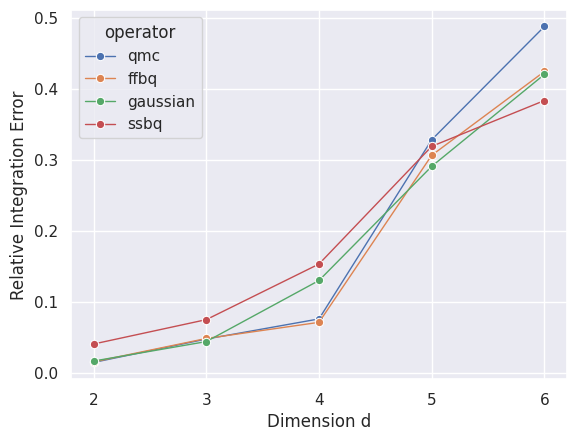

In [11]:
sns.set_theme()
fig = sns.lineplot(
    best_each_d, x="d", y="bqrel_mean", hue="operator", 
    linewidth=1, estimator="lowess", marker="o"
)
# fig.set(yscale="log")

# for operator, color in zip(best_each_d['operator'].unique(), sns.color_palette()):
#     subset = best_each_d[best_each_d['operator'] == operator]
#     plt.errorbar(x=subset['d'], y=subset['bqrel_mean'], yerr=subset['bqrel_std'], fmt='o', color=color, capsize=5)

plt.xlabel("Dimension d")
plt.ylabel("Relative Integration Error")

plt.show()

In [12]:
# best across d as a plurality
best_over_d = best_operator_plurality(d_sum, best_each_d)
best_over_d

,gptype,ktype,operator,sol,d,bqerr_mean,bqerr_std,bqrel_mean,bqrel_std,nll_mean,nll_std
0,gp,fin,qmc,0.1470510688313898,2,0.002105,0.001397,0.014314,0.009501,-2766.611011,54.139262
1,gp,fin,ffbq,0.1470510688313898,2,0.002215,0.001353,0.015062,0.009203,-2766.611011,54.139262
2,gp,rbf,gaussian,0.1470510688313898,2,0.002391,0.001323,0.016261,0.008995,-2428.531567,258.193675
3,lr,rff,ssbq,0.1470510688313898,2,0.005920,0.004822,0.040261,0.032794,-1024.337378,4.581887
4,gp,rbf,gaussian,0.05639002384646558,3,0.002465,0.001170,0.043709,0.020744,-2507.822119,254.014104
5,gp,fin,qmc,0.05639002384646558,3,0.002687,0.001293,0.047649,0.022926,-1171.078027,29.825443
6,gp,fin,ffbq,0.05639002384646558,3,0.002733,0.001635,0.048460,0.028999,-1171.078027,29.825443
7,lr,rff,ssbq,0.05639002384646558,3,0.004208,0.003820,0.074617,0.067742,-1047.865100,0.874184
8,gp,fin,ffbq,0.021624016844454134,4,0.001531,0.001219,0.070822,0.056363,333.113318,10.137656
9,gp,fin,qmc,0.021624016844454134,4,0.001636,0.001461,0.075646,0.067548,333.113318,10.137656


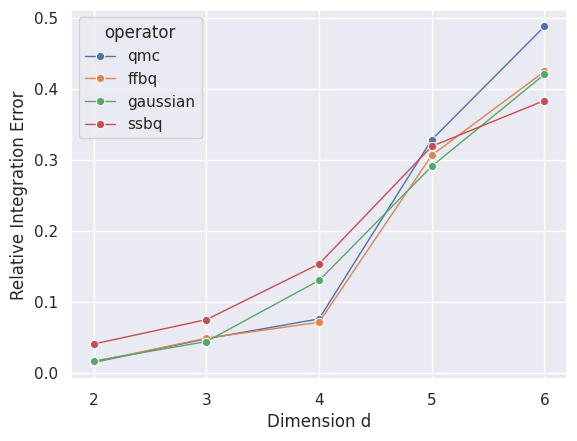

In [13]:
sns.set_theme()
fig = sns.lineplot(
    best_over_d, x="d", y="bqrel_mean", hue="operator", 
    linewidth=1, estimator="lowess", marker="o"
)
# fig.set(yscale="log")

# for operator, color in zip(best_each_d['operator'].unique(), sns.color_palette()):
#     subset = best_each_d[best_each_d['operator'] == operator]
#     plt.errorbar(x=subset['d'], y=subset['bqrel_mean'], yerr=subset['bqrel_std'], fmt='o', color=color, capsize=5)

plt.xlabel("Dimension d")
plt.ylabel("Relative Integration Error")

plt.show()

## Tables

In [22]:
paper_tab = best_over_d[["operator", "ktype", "d", "bqerr_mean", "bqerr_std"]]
paper_tab = paper_tab[paper_tab["d"].isin(['2', '4', '6'])]
paper_tab["model"] = paper_tab["operator"] + " " + paper_tab["ktype"]
paper_tab = paper_tab.drop(columns=["operator", "ktype"])
paper_tab_mean = paper_tab.pivot(index="model", columns="d", values="bqerr_mean").reset_index()
paper_tab_std = paper_tab.pivot(index="model", columns="d", values="bqerr_std").reset_index()
joint_df = paper_tab_mean.copy()

In [25]:
for col in ["2", "4", "6"]:
    joint_df[col] = joint_df[col].map("{:.2e}".format) + " ± " + paper_tab_std[col].map("{:.2e}".format)

In [27]:
joint_df.columns = ["model", "d = 2", "d=4", "d = 6"]

In [28]:
print(joint_df.iloc[[1, 2, 0, 3]].to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
model & d = 2 & d=4 & d = 6 \\
\midrule
gaussian rbf & 2.39e-03 ± 1.32e-03 & 2.81e-03 ± 2.00e-03 & 1.34e-03 ± 1.26e-03 \\
qmc fin & 2.10e-03 ± 1.40e-03 & 1.64e-03 ± 1.46e-03 & 1.55e-03 ± 7.24e-04 \\
ffbq fin & 2.21e-03 ± 1.35e-03 & 1.53e-03 ± 1.22e-03 & 1.35e-03 ± 7.46e-04 \\
ssbq rff & 5.92e-03 ± 4.82e-03 & 3.31e-03 ± 2.03e-03 & 1.22e-03 ± 1.22e-03 \\
\bottomrule
\end{tabular}



### Plots

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_qmc_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="mc", s=5)
# ax.scatter(X_train[:, 0], X_train[:, 1], rff_fft_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X_train[:, 0], X_train[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X_train[:, 0], X_train[:, 1], rbf_fft_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

# ax.legend()

# Dev

In [19]:
from ffbq.helpers import area, stabilize
from ffbq.conv import rff_conv

In [14]:
keys = jax.random.split(key, 10)
res = single_run(d=5, R=100, N=1000, sampling_rate=10.5, key=keys[0], EXPERIMENT="continuous_var_dev", log=False)
# runs = multi_seed_run(d=3, R=100, N=1000, sampling_rate=12, global_key=key, n_runs=10, log=False)

# gp_rbf = res["gps"]["rbf"]
# gp_fin = res["gps"]["fin"]
# lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
# m = res["m"]
# genz = res["genz"]
# Nconv = grid(genz.bounds, 16).shape[0]
# grid_dims = grid(genz.bounds, 16, flatten=False).shape[:-1]

# rbf_res, rbf_var, _ = gaussian_bq(gp_rbf, m, X, y, key, diag=1e-1)
# lrqmc_res, lrqmc_var = lr_qmc_bq(lr_rbf, m, X, y, min(Nconv, 500000), diag=1e-1)

# bq = BQ(gp_rbf, m)
# bq_lr = BQ(lr_rbf, m, operator="lr")
# bq_fft = BQ(gp_rbf, m, operator="fft")

# bq_z, bq_Z = bq.kmu_kvar(X, bounds=genz.bounds, key=key)
# fft_z, fft_Z = bq_fft.kmu_kvar(X, sr=32, bounds=genz.bounds, bounded=True)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.view_init(elev=0., azim=0)
# ax.scatter(X[:, 0], X[:, 1], rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="bq", s=5)
# ax.scatter(X[:, 0], X[:, 1], qmc_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="qmc", s=5)
# ax.scatter(X[:, 0], X[:, 1], fft_rbf_z, cmap=cm.viridis, linewidth=0, antialiased=True, label="fft", s=5)

d: 5, R: 100, N: 1000, sr: 10.5
training basic gp...
training rbf gp...
training finite gp...
training low rank rbf gp...
training low rank matern 3/2 gp...
training low rank RFF gp...
running BQ models...
Capping N mc from 4084101 to 100000
Capping N RFF from 4084101 to 500000

        Gaussian: 0.45694205164909363 
 
        MC: [0.35997579 0.27942935 0.36445224] 

        QMC: [0.4472837  0.355915   0.45213416] 
 
        FFBQ: [0.5073409  0.41337934 0.5125752 ] 
 
        SSBQ (QMC): [0.47983107 0.36080512 0.50938916] 

        SSBQ (FFT): None 

    


In [15]:
sr_ = 10.5
key2 = keys[5]
gp_bq = res["gps"]["bq"]
gp_rbf = res["gps"]["rbf"]
gp_fin = res["gps"]["fin"]
lr_rbf = res["gps"]["lr_rbf"]
# X, y = res["val"]
m = res["m"]
genz = res["genz"]
X, _, y = genz.sample(1000, key=key2)
Nconv = grid(genz.bounds, sr_).shape[0]
grid_dims = grid(genz.bounds, sr_, flatten=False).shape[:-1]
sol = sols2_d[4]

In [16]:
def full_cov(gp, y, X_test, diag=None):
    K = gp.kernel(gp.X, gp.X)
    if diag is None:
        diag = jnp.trace(K) * 0.001

    K = K + jnp.eye(gp.X.shape[0]) * diag
    K_star = gp.kernel(gp.X, X_test)
    K_star_star = gp.kernel(X_test, X_test) + jnp.eye(X_test.shape[0]) * diag

    alpha, _ = jax.scipy.sparse.linalg.cg(lambda v: jnp.dot(K, v), y)

    mu_s = jnp.dot(K_star.T, alpha)
    cov_s = K_star_star - jnp.dot(K_star.T, jnp.linalg.solve(K, K_star))
    cov_s = stabilize(cov_s)[0]
    
    return mu_s, cov_s

In [17]:
def full_cov_lr(lrgp, y, X_test, diag=None):
    X_test = lrgp.kernel.evaluate(X_test)
    X_tr = lrgp.kernel.evaluate(lrgp.X)
    phi_tr = lrgp.kernel.kernel.phi(X_tr)
    phi_te = lrgp.kernel.kernel.phi(X_test)
    R = phi_tr.shape[1]
    N = phi_te.shape[0]

    A = phi_tr.T @ phi_tr
    if diag is None:
        diag = jnp.trace(A) * 0.0001
    if jnp.isnan(diag) or diag < 0:
        diag = 1e-3
    A = A + jnp.eye(R) * diag
    A_inv = jnp.linalg.inv(A)

    mu = phi_te @ A_inv @ phi_tr.T @ y
    cov = phi_te @ A_inv @ phi_te.T
    cov = jnp.clip(stabilize(cov)[0], 0, None)
    cov = cov + jnp.eye(N) * diag

    return mu, cov
    # A = stabilize(A, alpha=diag)[0]

In [34]:
Xt = qmc(keys[2], m, 5000, genz.bounds)
mu, cov = full_cov(gp_fin, y, Xt)

d_post = jax.random.multivariate_normal(key2, mu, jnp.clip(cov, 0, None), shape=(30000,))
mc_fints = d_post.mean(axis=1)
mc_mu = mc_fints.mean() * area(genz.bounds)
mc_var = mc_fints.std()**2
mc_mu, mc_var, mc_var**0.5

(Array(0.00560247, dtype=float32),
 Array(0.00143744, dtype=float32),
 Array(0.03791359, dtype=float32))

In [35]:
mu_lr, cov_lr = full_cov_lr(lr_rbf, y, Xt, diag=3e-1)
d_post_lr = jax.random.multivariate_normal(key2, mu_lr, cov_lr, shape=(30000,))

mc_fints_lr = d_post_lr.mean(axis=1)
mc_mu_lr = mc_fints_lr.mean() * area(genz.bounds)
mc_var_lr = mc_fints_lr.std()**2
mc_mu_lr, mc_var_lr, mc_var_lr**0.5

(Array(0.00725751, dtype=float32),
 Array(0.00152799, dtype=float32),
 Array(0.03908946, dtype=float32))

In [36]:
bq = BQ(gp_bq, m)
bq_qmc = BQ(gp_fin, m, operator="qmc")
bq_fft = BQ(gp_fin, m, operator="fft")
bq_lr = BQ(lr_rbf, m, operator="lr")

In [37]:
bq_z, bq_Z = bq.kmu_kvar(X, bounds=genz.bounds, key=key2)
qmc_z, qmc_Z = bq_qmc.kmu_kvar(X, bounds=genz.bounds, R=min(Nconv, 100000), key=key2)
fft_z, fft_Z = bq_fft.kmu_kvar(X, bounds=genz.bounds, sr=sr_, bounded=True)
lr_z, lr_Z = bq_lr.kmu_kvar(X, bounds=genz.bounds, R=min(Nconv, 500000), key=key2)

In [38]:
bq_res, bq_var = bq(X, y, bounds=genz.bounds, key=key2, R=20000)
qmc_res, qmc_var = bq_qmc(X, y, bounds=genz.bounds, R=min(Nconv, 100000), key=key2)
fft_res, fft_var = bq_fft(X, y, bounds=genz.bounds, sr=sr_, bounded=True)
lr_res, lr_var = bq_lr(X, y, bounds=genz.bounds, R=min(Nconv, 500000), key=key2)

In [39]:
mus = jnp.array([bq_res, qmc_res, fft_res, lr_res])
Zs = jnp.array([bq_Z, qmc_Z, fft_Z, lr_Z])
vars = jnp.array([bq_var, qmc_var, fft_var, lr_var])
mus, Zs, vars, vars**0.5

(Array([0.00704976, 0.00584571, 0.00616508, 0.00694774], dtype=float32),
 Array([866.1349   ,   2.002346 ,   2.6042373,   0.9099076], dtype=float32),
 Array([0.00100154, 0.00050925, 0.00071129, 0.00101168], dtype=float32),
 Array([0.03164707, 0.02256649, 0.02666997, 0.03180688], dtype=float32))